In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

In [4]:
new=pd.read_csv('final_df.csv',encoding='utf-8')

In [5]:
df1=pd.read_csv('mongo_docs.csv',encoding='utf-8')
df1.drop(['repo_name','owner','api_age'], axis=1, inplace=True)
new['api_spec_id'].isin(df1['id']).value_counts()

api_spec_id
True    75969
Name: count, dtype: int64

In [6]:
df=pd.concat([new,df1],axis=1, join='inner')

In [7]:
df.drop (['id'], axis=1, inplace=True)

In [8]:
df['commit_date']=pd.to_datetime(df['commit_date'])
df['time_diff'] = df.groupby('api_spec_id')['commit_date'].diff() / np.timedelta64(1, 'D')
df['time_diff'] = df['time_diff'].fillna(0)
df['time_diff']= df['time_diff'].round(decimals =0)
df['time_diff']= df['time_diff'].astype(int)

In [9]:
df['type_of_change'] = np.where(df['errors'].isna(), 'Non-Breaking', np.where(df['errors'].str.contains('errors'), 'Breaking', 'Non-Breaking'))

In [10]:
df['type_of_change'].value_counts()

type_of_change
Non-Breaking    64046
Breaking        11923
Name: count, dtype: int64

In [11]:
df['Total_Breaking_Changes']=df.groupby('api_spec_id')['count'].transform('sum')

In [12]:
df['label'] = df['label'].replace(np.nan,'nan')

In [13]:
df[['commit_date']] = df[['commit_date']].apply(pd.to_datetime)

g = df.groupby('api_spec_id')['commit_date']
df['Age (in days)'] = g.transform('max').sub(g.transform('min'))

In [14]:
df['Age'] = df['Age (in days)'].dt.days

In [15]:
df['Age'].groupby(df['label']).value_counts().to_csv('age.csv')

In [16]:
df.drop(['Age (in days)'], axis=1, inplace=True)

In [17]:
df['Age']= df['Age'].astype(int)

In [18]:
df['Age'].describe()

count    75969.000000
mean       594.200490
std        490.204047
min          0.000000
25%        176.000000
50%        506.000000
75%        882.000000
max       2557.000000
Name: Age, dtype: float64

In [19]:
df['Total_API_Changes']=df.groupby('api_spec_id')['API_changes'].transform('sum')

In [20]:
df['Total_Breaking_Changes']= df['Total_Breaking_Changes'].astype(int)

In [21]:
df['Total_API_Changes']= df['Total_API_Changes'].astype(int)

In [22]:
df['content'] = df['content'].replace(np.nan, 'nan')

In [23]:
breaking_changes=df.query("type_of_change=='Breaking'")

In [24]:
avg_time_diff=breaking_changes.groupby('api_spec_id')['time_diff'].mean()
df = pd.merge(df, avg_time_diff, on='api_spec_id', how='left')

In [25]:
df['time_diff_y']= df['time_diff_y'].round(decimals =1)

In [27]:
# Define valid label options
valid_labels = ['major', 'minor', 'patch', 'nan', 'major.minor', 'minor.patch','major.minor.patch']

label = input(f"Enter the label ({', '.join(valid_labels)}): ")
age_range = input("Enter the age range (e.g. '20-30'): ")
use_type_of_change_filter = input("Do you want to filter by type of change? (y/n): ")
if use_type_of_change_filter.lower() == 'y':
    type_of_change = input("Enter the type of change (breaking/non-breaking): ")
else:
    type_of_change = None

use_total_changes_filter = input("Do you want to filter by Total_Breaking_Changes or Total_API_changes? (y/n): ")
if use_total_changes_filter.lower() == 'y':
    total_breaking_changes_range = input("Enter the Total_Breaking_Changes range (e.g. '1-10'): ")
    total_api_changes_range = input("Enter the Total_API_changes range (e.g. '10-20'): ")
else:
    total_breaking_changes_range = None
    total_api_changes_range = None

print(f"Label: {label}, Age_range: {age_range}, Type_of_change: {type_of_change}, Total_breaking_changes_range: {total_breaking_changes_range}, Total_api_changes_range: {total_api_changes_range}")
def filter_data(df, label=None, age_range=None, type_of_change=None, total_breaking_changes_range=None, total_api_changes_range=None):
    filtered_df = pd.DataFrame(df)

    # Filter by label
    if label is not None:
        filtered_df = filtered_df[filtered_df['label'] == label]

    # Filter by age range
    if age_range is not None:
        min_age, max_age = map(int, age_range.split('-'))
        filtered_df = filtered_df[(filtered_df['Age'] >= min_age) & (filtered_df['Age'] <= max_age)]

    # Filter by type of change
    if type_of_change is not None:
        filtered_df = filtered_df[filtered_df['type_of_change'] == type_of_change]

    # Filter by total breaking changes range
    if total_breaking_changes_range is not None:
        min_changes, max_changes = map(int, total_breaking_changes_range.split('-'))
        filtered_df = filtered_df[(filtered_df['Total_Breaking_Changes'] >= min_changes) & (filtered_df['Total_Breaking_Changes'] <= max_changes)]

    # Filter by total API changes range
    if total_api_changes_range is not None:
        min_changes, max_changes = map(int, total_api_changes_range.split('-'))
        filtered_df = filtered_df[(filtered_df['Total_API_Changes'] >= min_changes) & (filtered_df['Total_API_Changes'] <= max_changes)]

    return filtered_df

filtered_df = filter_data(df,label, age_range, type_of_change, total_breaking_changes_range, total_api_changes_range)

if not filtered_df.empty:
    unique_api_spec_ids = filtered_df['api_spec_id'].unique()
    print(unique_api_spec_ids)
else:
    print("No api_spec_ids match your input.")

if not filtered_df.empty:
    unique_api_spec_ids = filtered_df['api_spec_id'].unique()
    print(len(unique_api_spec_ids))
else:
    print("No api_spec_ids match your input.")

Label: nan, Age_range: 200-300, Type_of_change: None, Total_breaking_changes_range: None, Total_api_changes_range: None
[  7338.   7918.   8282.   8892.  10000.  27514.  29116.  47959.  52705.
  54022.  58508.  61499.  61812.  64020.  64110.  65942.  66373.  67469.
  68283.  70123.  75796.  81324.  84248.  86542.  86805.  90387.  93435.
  93672.  93808.  95414.  95563.  97408.  97954. 100708. 102289. 102336.
 102369. 102421. 102486. 102504. 103658. 105762. 106524. 108424. 110687.
 112071. 112889. 116197. 118500. 118651. 118680. 119620. 119936. 119967.
 122498. 122805. 122810. 122812. 122819. 122822. 124177. 124902. 125036.
 125066. 125488. 125959. 126510. 127534. 127537. 127542. 127545. 129000.
 129550. 133449. 134008. 135423. 137223. 139384. 139946. 143593. 151486.
 152433. 153167. 154095. 154504. 154597. 154771. 156118. 156435. 157305.
 157382. 157484. 158030. 161019. 162588. 170795. 174729. 179083. 179651.
 180178. 180621. 184483. 184757. 184956. 187844. 188990. 189601. 189911.
 190

In [34]:
data=df.query("api_spec_id==194893").sort_values(by=['commit_date'])

data['commit_date']=pd.to_datetime(data['commit_date'])
data['Year']= data['commit_date'].dt.year

data['type1'] = data['count'].apply(lambda x: 'Breaking' if pd.notna(x) else 'Nan')

data.fillna(0, inplace=True)
data[['Year','Month','Day','API_changes','type1','count']]

,Year,Month,Day,API_changes,type1,count
28057,2019,September,20,7.0,Nan,0.0
28058,2019,September,23,29.0,Breaking,2.0
28059,2019,September,23,11.0,Nan,0.0
28060,2019,September,24,9.0,Breaking,2.0
28061,2019,October,17,11.0,Breaking,1.0
28062,2019,November,17,9.0,Nan,0.0
28063,2019,November,21,22.0,Breaking,2.0
28064,2019,November,26,15.0,Breaking,2.0
28065,2020,January,8,61.0,Breaking,15.0
28066,2020,February,5,11.0,Breaking,2.0


In [35]:
data=df.query("api_spec_id==199399").sort_values(by=['commit_date'])

data['commit_date']=pd.to_datetime(data['commit_date'])
data['Year']= data['commit_date'].dt.year

data['type1'] = data['count'].apply(lambda x: 'Breaking' if pd.notna(x) else 'Nan')

data.fillna(0, inplace=True)
data[['Year','Month','Day','API_changes','type1','count','commit_date','Age']]

,Year,Month,Day,API_changes,type1,count,commit_date,Age
30875,2020,November,30,7.0,Nan,0.0,2020-11-30,485
30876,2021,January,4,52.0,Breaking,28.0,2021-01-04,485
30877,2021,January,11,13.0,Breaking,42.0,2021-01-11,485
30878,2021,January,11,13.0,Breaking,2.0,2021-01-11,485
30879,2021,August,3,56.0,Breaking,5.0,2021-08-03,485
30880,2021,September,15,16.0,Nan,0.0,2021-09-15,485
30881,2021,September,16,15.0,Breaking,2.0,2021-09-16,485
30882,2021,September,24,14.0,Nan,0.0,2021-09-24,485
30883,2022,February,14,17.0,Breaking,1.0,2022-02-14,485
30884,2022,February,15,13.0,Breaking,3.0,2022-02-15,485


In [36]:
data=df.query("api_spec_id==200143").sort_values(by=['commit_date'])

data['commit_date']=pd.to_datetime(data['commit_date'])
data['Year']= data['commit_date'].dt.year

data['type1'] = data['count'].apply(lambda x: 'Breaking' if pd.notna(x) else 'Nan')

data.fillna(0, inplace=True)
data[['Year','Month','Day','API_changes','type1','count','commit_date','Age']]

,Year,Month,Day,API_changes,type1,count,commit_date,Age
31430,2018,April,23,7.0,Nan,0.0,2018-04-23,501
31431,2018,May,6,59.0,Breaking,7.0,2018-05-06,501
31432,2018,May,8,61.0,Breaking,9.0,2018-05-08,501
31433,2018,May,9,59.0,Breaking,7.0,2018-05-09,501
31434,2018,July,8,21.0,Breaking,2.0,2018-07-08,501
31435,2018,August,5,13.0,Breaking,2.0,2018-08-05,501
31436,2018,September,20,7.0,Nan,0.0,2018-09-20,501
31437,2018,September,29,58.0,Breaking,9.0,2018-09-29,501
31438,2018,October,23,16.0,Breaking,4.0,2018-10-23,501
31439,2018,October,29,9.0,Nan,0.0,2018-10-29,501


In [ ]:
data=df.query("api_spec_id==200143").sort_values(by=['commit_date'])

data['commit_date']=pd.to_datetime(data['commit_date'])
data['Year']= data['commit_date'].dt.year


data['type1'] = data['count'].apply(lambda x: 'Breaking' if pd.notna(x) else 'Nan')


data.fillna(0, inplace=True)
data[['Year','Month','Day','API_changes','type1','count','commit_date','Age']]

,Year,Month,Day,API_changes,type1,count,commit_date,Age
31430,2018,April,23,7.0,Nan,0.0,2018-04-23 06:10:50,501
31431,2018,May,6,59.0,Breaking,7.0,2018-05-06 13:56:59,501
31432,2018,May,8,61.0,Breaking,9.0,2018-05-08 06:44:51,501
31433,2018,May,9,59.0,Breaking,7.0,2018-05-09 00:31:28,501
31434,2018,July,8,21.0,Breaking,2.0,2018-07-08 02:46:35,501
31435,2018,August,5,13.0,Breaking,2.0,2018-08-05 18:11:52,501
31436,2018,September,20,7.0,Nan,0.0,2018-09-20 09:29:33,501
31437,2018,September,29,58.0,Breaking,9.0,2018-09-29 07:21:03,501
31438,2018,October,23,16.0,Breaking,4.0,2018-10-23 06:51:55,501
31439,2018,October,29,9.0,Nan,0.0,2018-10-29 06:42:32,501


In [29]:
g = df.groupby('api_spec_id')['commit_date']
df['Age2'] = g.transform('max').sub(g.transform('min'))

In [30]:
df['commit_date'] = pd.to_datetime(df['commit_date'])
df['commit_date'] = df['commit_date'].dt.strftime('%Y-%m-%d')

In [31]:
df['Timeline'] = 'Evolution'


In [32]:
df['Overall'] = 'Age'

In [33]:
df['commit_date'] = pd.to_datetime(df['commit_date'])
df['Month'] = df['commit_date'].dt.month_name()
df['Day'] = df['commit_date'].dt.day

## Early Evolution

In [37]:
data=df.query("api_spec_id==227296").sort_values(by=['commit_date'])

data['Count2'] = data.apply(lambda x: x['API_changes'] - x['count'] if pd.notnull(x['count']) else None, axis=1)

# add api_changes to Count2 where Count2 is null
data['Count2'] = data.apply(lambda x: x['API_changes'] if pd.isnull(x['Count2']) else x['Count2'], axis=1)

data['commit_date']=pd.to_datetime(data['commit_date'])
data['Year']= data['commit_date'].dt.year

first_commit_date = data['commit_date'].min()
data['time_diff_new'] = (data['commit_date'] - first_commit_date).dt.days

data['type1'] = data['count'].apply(lambda x: 'Breaking' if pd.notna(x) else 'Nan')


data.fillna(0, inplace=True)
data1= data[['Year','Month','Day','API_changes','type1']]

In [ ]:
df.to_csv('prac.csv', index=False)

In [ ]:
newdf = data1.copy()  # in case we need the original df
edata = newdf.to_dict('records')

In [ ]:
pip install -U kaleido

  Using cached kaleido-0.2.1-py2.py3-none-macosx_10_11_x86_64.whl (85.2 MB)

[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


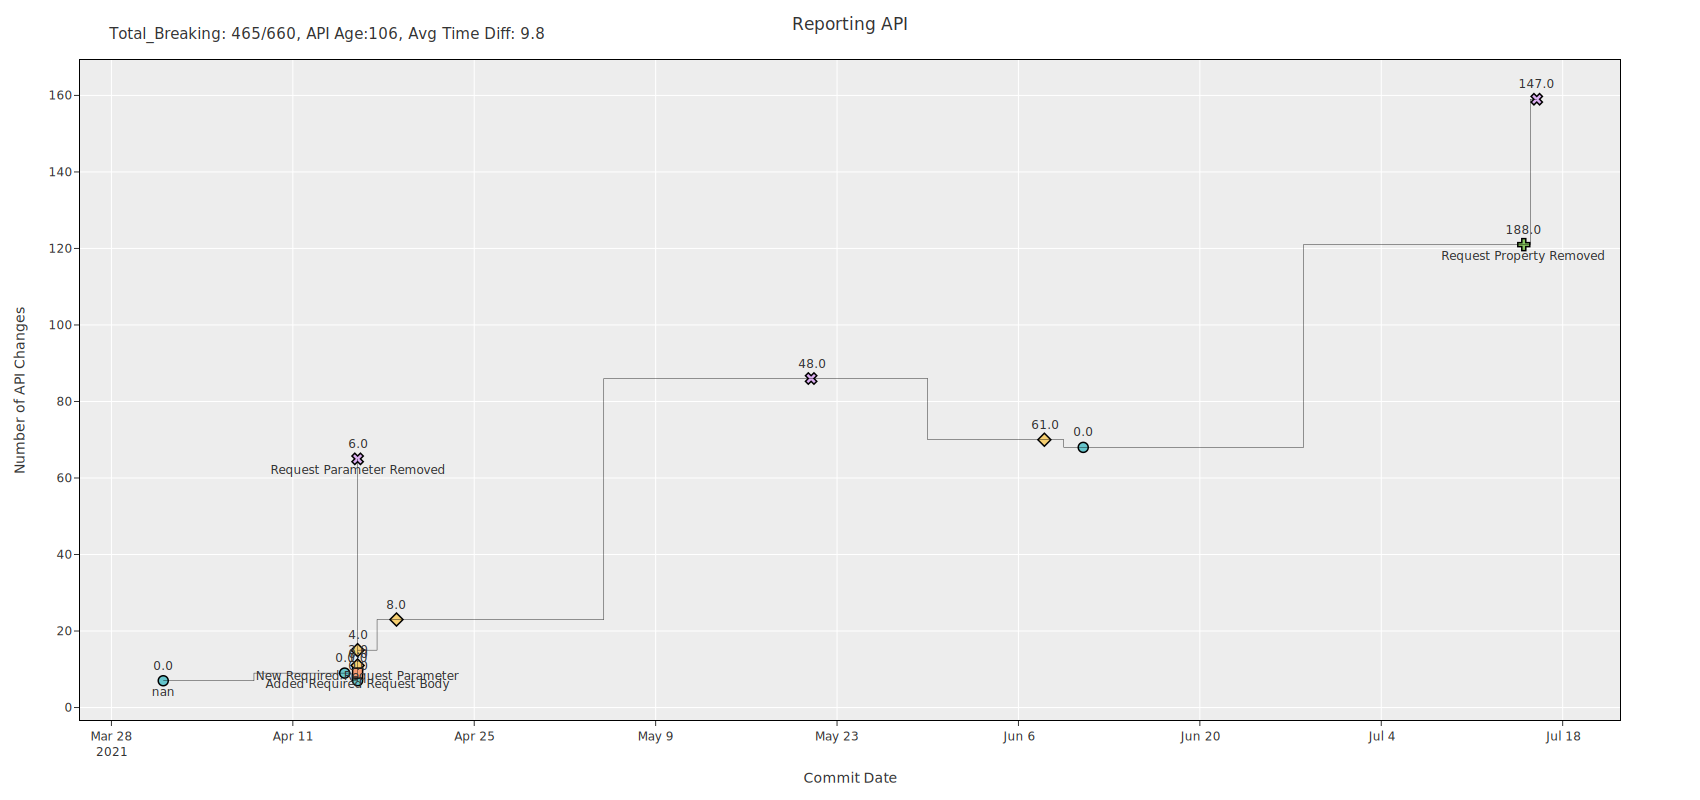

In [61]:
data= df.query("api_spec_id==158044").sort_values(by='commit_date',ascending=True)
data.fillna(0, inplace=True)
data['commit_date'] = pd.to_datetime(df['commit_date'])
data['dupe'] = data.content.where(~data.content.duplicated(), '')
#data['dupe3']= data['count'].where(~data['count'].duplicated(), '')

import plotly.graph_objects as go
fig = go.Figure()

fig = px.scatter(data, x='commit_date', y='API_changes', color='content',symbol='content', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.add_trace(go.Scatter(mode='lines',
                         x=data["commit_date"],
                         y=data["API_changes"],
                         line_color='black',
                         line_width=0.4,
                         line_shape='hvh',
                         showlegend=False
                       )
             )

for _,row in data.iterrows():
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe'],
            showarrow=False,
            align='center',
            yanchor='bottom',
            yshift=-20,
            textangle=0)
       )
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['count'],
            showarrow=False,
            align='center',
            yanchor='top',
            yshift=25,
            textangle=0)
       )
fig.add_annotation(
    showarrow=False,
    text= f"Total_Breaking: {row['Total_Breaking_Changes']}/{row['Total_API_Changes']}, API Age:{row['Age']}, Avg Time Diff: {row['time_diff_y']}",
    xref='paper',
    font=dict(size=15),
    x=0.014,
    yref='paper',
    y=1.057
)

fig.update_layout(template='ggplot2',legend_title = 'Type of Breaking Change', title=" Reporting API", xaxis_title="Commit Date", yaxis_title="Number of API Changes",height=800,width=1700)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_traces(marker_size=10, marker_line_width=1.5, marker_line_color='black', showlegend=False, textposition='bottom center')

fig.show("svg")


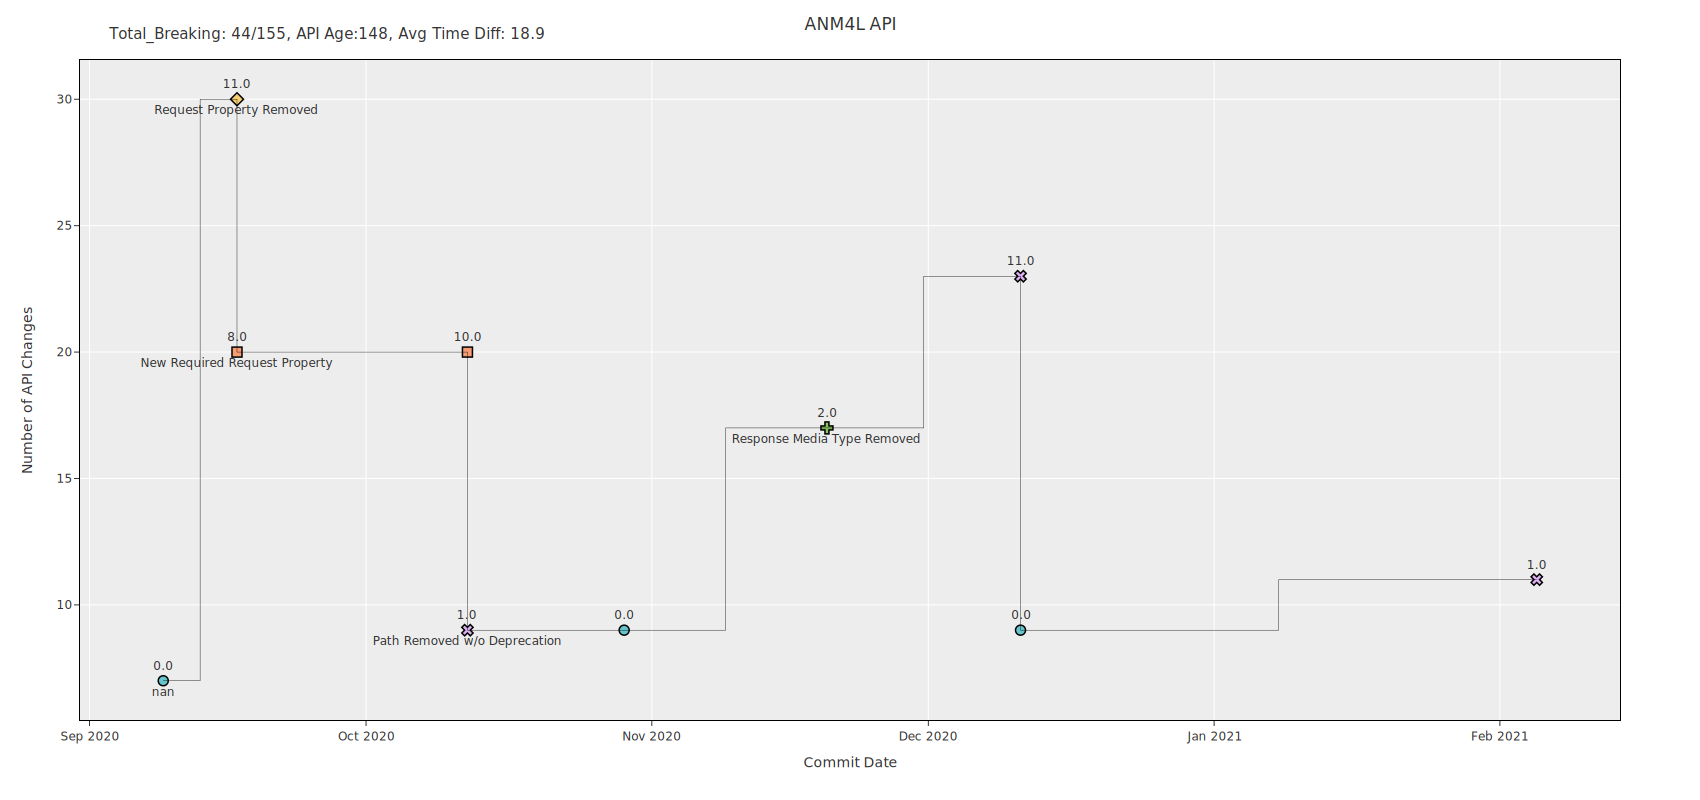

In [62]:
data= df.query("api_spec_id==109958").sort_values(by='commit_date',ascending=True)
data.fillna(0, inplace=True)
data['commit_date'] = pd.to_datetime(df['commit_date'])
data['dupe'] = data.content.where(~data.content.duplicated(), '')
#data['dupe3']= data['count'].where(~data['count'].duplicated(), '')

import plotly.graph_objects as go
fig = go.Figure()

fig = px.scatter(data, x='commit_date', y='API_changes', color='content',symbol='content', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.add_trace(go.Scatter(mode='lines',
                         x=data["commit_date"],
                         y=data["API_changes"],
                         line_color='black',
                         line_width=0.4,
                         line_shape='hvh',
                         showlegend=False
                       )
             )

for _,row in data.iterrows():
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe'],
            showarrow=False,
            align='center',
            yanchor='bottom',
            yshift=-20,
            textangle=0)
       )
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['count'],
            showarrow=False,
            align='center',
            yanchor='top',
            yshift=25,
            textangle=0)
       )
fig.add_annotation(
    showarrow=False,
    text= f"Total_Breaking: {row['Total_Breaking_Changes']}/{row['Total_API_Changes']}, API Age:{row['Age']}, Avg Time Diff: {row['time_diff_y']}",
    xref='paper',
    font=dict(size=15),
    x=0.014,
    yref='paper',
    y=1.057
)

fig.update_layout(template='ggplot2',legend_title = 'Type of Breaking Change', title="ANM4L API", xaxis_title="Commit Date", yaxis_title="Number of API Changes",height=800,width=1700)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_traces(marker_size=10, marker_line_width=1.5, marker_line_color='black', showlegend=False, textposition='bottom center')

fig.show("svg")


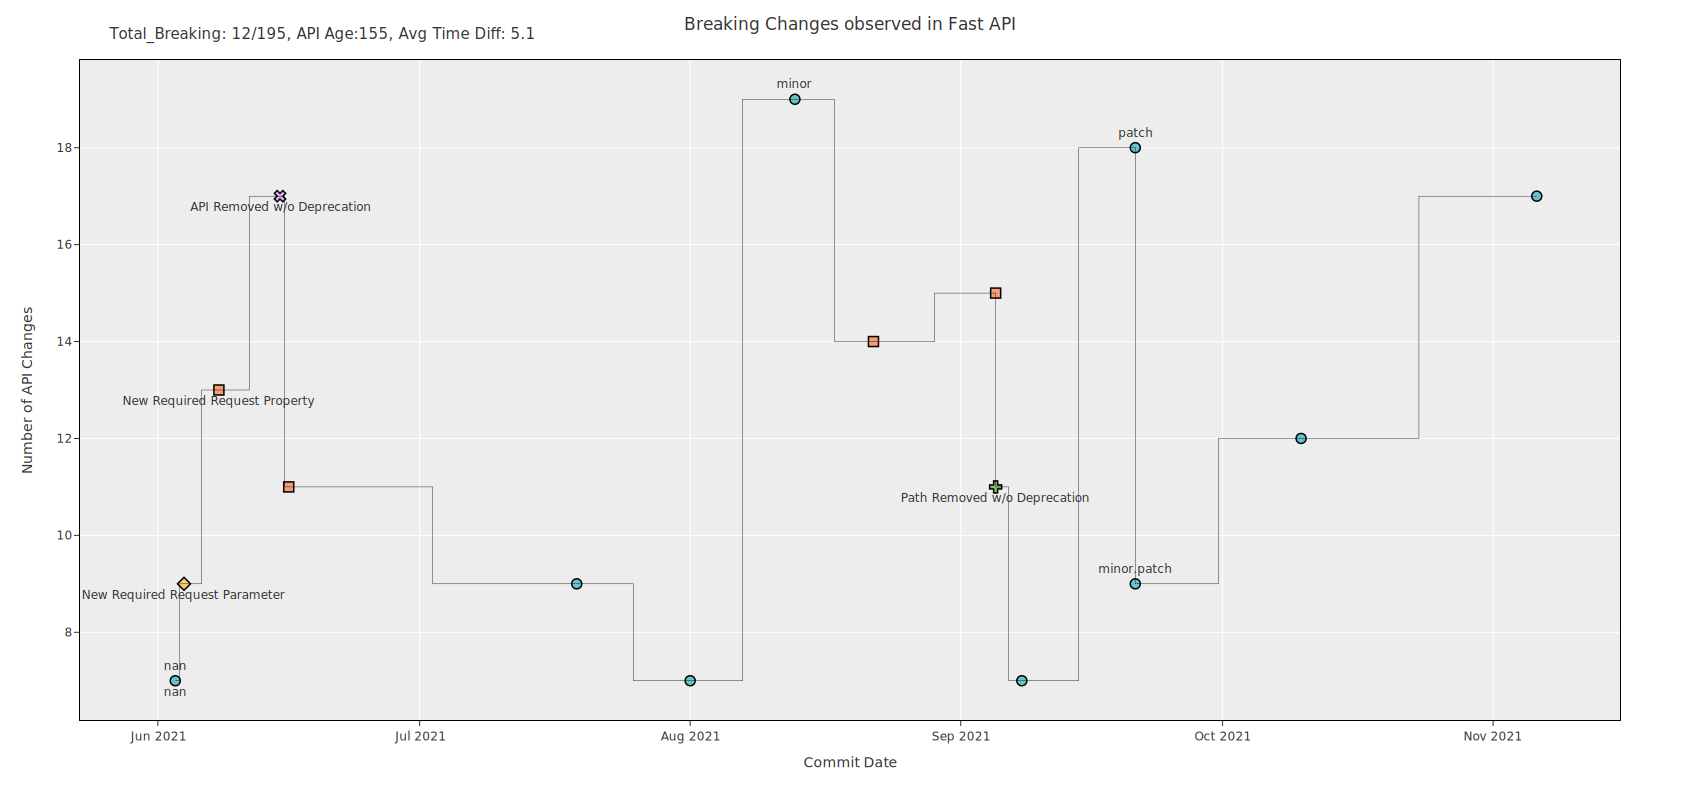

In [63]:
data= df.query("api_spec_id==66348").sort_values(by='commit_date',ascending=True)
data.fillna(0, inplace=True)
data['commit_date'] = pd.to_datetime(df['commit_date'])
data['dupe'] = data.content.where(~data.content.duplicated(), '')
data['dupe2']= data['label'].where(~data['label'].duplicated(), '')
#data['dupe3']= data['count'].where(~data['count'].duplicated(), '')

import plotly.graph_objects as go
fig = go.Figure()

fig = px.scatter(data, x='commit_date', y='API_changes', color='content',symbol='content', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.add_trace(go.Scatter(mode='lines',
                         x=data["commit_date"],
                         y=data["API_changes"],
                         line_color='black',
                         line_width=0.4,
                         line_shape='hvh',
                         showlegend=False
                       )
             )

for _,row in data.iterrows():
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe'],
            showarrow=False,
            align='center',
            yanchor='bottom',
            yshift=-20,
            textangle=0)
       )
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe2'],
            showarrow=False,
            align='center',
            yanchor='top',
            yshift=25,
            textangle=0)
       )
fig.add_annotation(
    showarrow=False,
    text= f"Total_Breaking: {row['Total_Breaking_Changes']}/{row['Total_API_Changes']}, API Age:{row['Age']}, Avg Time Diff: {row['time_diff_y']}",
    xref='paper',
    font=dict(size=15),
    x=0.014,
    yref='paper',
    y=1.057
)

fig.update_layout(template='ggplot2',legend_title = 'Type of Breaking Change', title="Breaking Changes observed in Fast API", xaxis_title="Commit Date", yaxis_title="Number of API Changes",height=800,width=1700)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_traces(marker_size=10, marker_line_width=1.5, marker_line_color='black', showlegend=False, textposition='bottom center')

fig.show("svg")


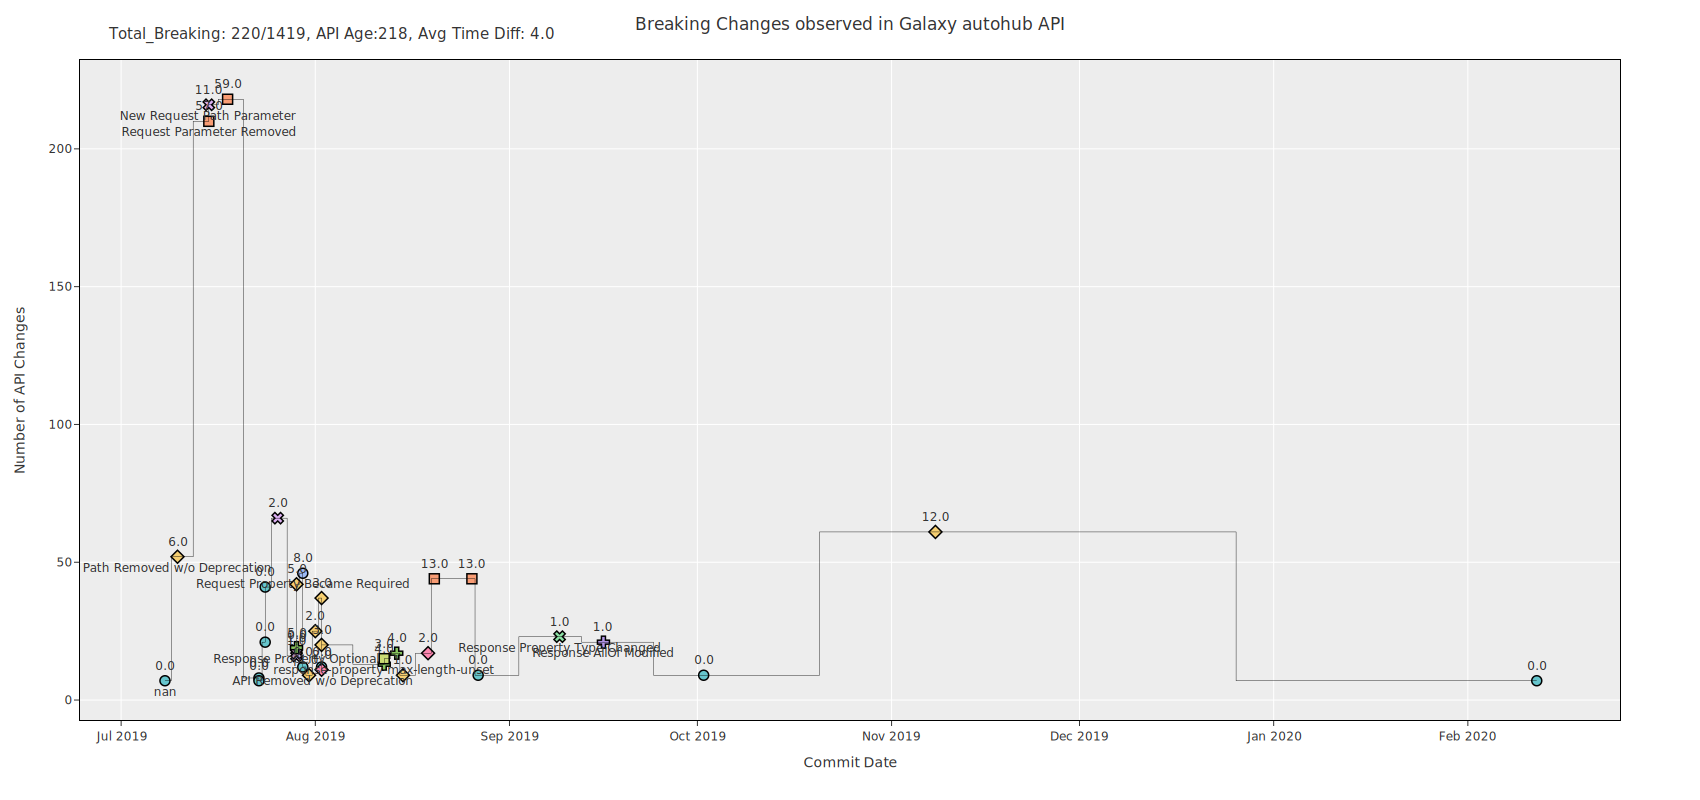

In [64]:
data= df.query("api_spec_id==7918").sort_values(by='commit_date',ascending=True)
data.fillna(0, inplace=True)
data['commit_date'] = pd.to_datetime(df['commit_date'])
data['dupe'] = data.content.where(~data.content.duplicated(), '')
#data['dupe3']= data['count'].where(~data['count'].duplicated(), '')

import plotly.graph_objects as go
fig = go.Figure()

fig = px.scatter(data, x='commit_date', y='API_changes', color='content',symbol='content', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.add_trace(go.Scatter(mode='lines',
                         x=data["commit_date"],
                         y=data["API_changes"],
                         line_color='black',
                         line_width=0.4,
                         line_shape='hvh',
                         showlegend=False
                       )
             )

for _,row in data.iterrows():
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe'],
            showarrow=False,
            align='center',
            yanchor='bottom',
            yshift=-20,
            textangle=0)
       )
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['count'],
            showarrow=False,
            align='center',
            yanchor='top',
            yshift=25,
            textangle=0)
       )
fig.add_annotation(
    showarrow=False,
    text= f"Total_Breaking: {row['Total_Breaking_Changes']}/{row['Total_API_Changes']}, API Age:{row['Age']}, Avg Time Diff: {row['time_diff_y']}",
    xref='paper',
    font=dict(size=15),
    x=0.014,
    yref='paper',
    y=1.057
)
fig.update_layout(template='ggplot2',legend_title = 'Type of Breaking Change', title="Breaking Changes observed in Galaxy autohub API", xaxis_title="Commit Date", yaxis_title="Number of API Changes",height=800,width=1700)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_traces(marker_size=10, marker_line_width=1.5, marker_line_color='black', showlegend=False, textposition='bottom center')


fig.show("svg")


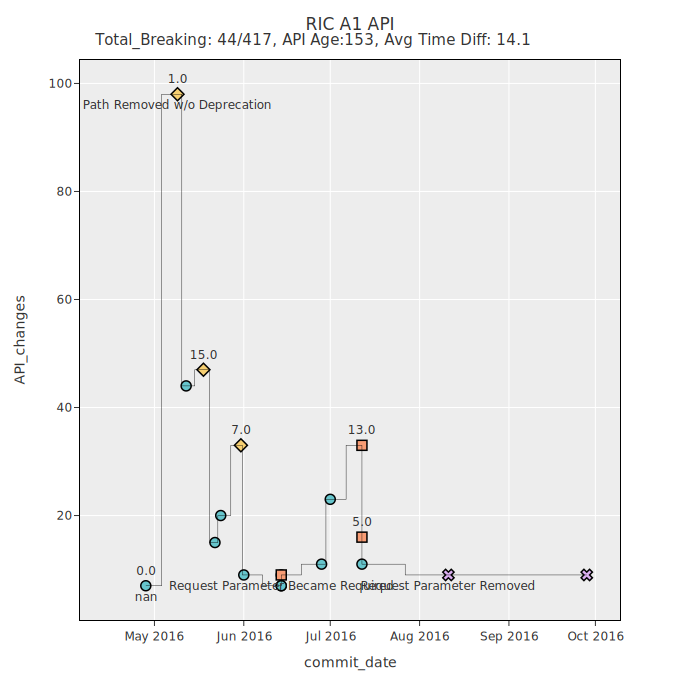

In [65]:
data= df.query("api_spec_id==118407").sort_values(by='commit_date',ascending=True)
data.fillna(0, inplace=True)
data['commit_date'] = pd.to_datetime(df['commit_date'])
data['dupe'] = data.content.where(~data.content.duplicated(), '')
data['dupe3']= data['count'].where(~data['count'].duplicated(), '')

import plotly.graph_objects as go
fig = go.Figure()

fig = px.scatter(data, x='commit_date', y='API_changes', color='content',symbol='content', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.add_trace(go.Scatter(mode='lines',
                         x=data["commit_date"],
                         y=data["API_changes"],
                         line_color='black',
                         line_width=0.4,
                         line_shape='hvh',
                         showlegend=False
                       )
             )

for _,row in data.iterrows():
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe'],
            showarrow=False,
            align='center',
            yanchor='bottom',
            yshift=-20,
            textangle=0)
       )
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe3'],
            showarrow=False,
            align='center',
            yanchor='top',
            yshift=25,
            textangle=0)
       )
fig.add_annotation(
    showarrow=False,
    text= f"Total_Breaking: {row['Total_Breaking_Changes']}/{row['Total_API_Changes']}, API Age:{row['Age']}, Avg Time Diff: {row['time_diff_y']}",
    xref='paper',
    font=dict(size=15),
    x=0.014,
    yref='paper',
    y=1.057
)
fig.update_layout(template='ggplot2',legend_title = 'Type of Breaking Change', title="RIC A1 API",height=700)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_traces(marker_size=10, marker_line_width=1.5, marker_line_color='black', showlegend=False, textposition='bottom center')


fig.show("svg")


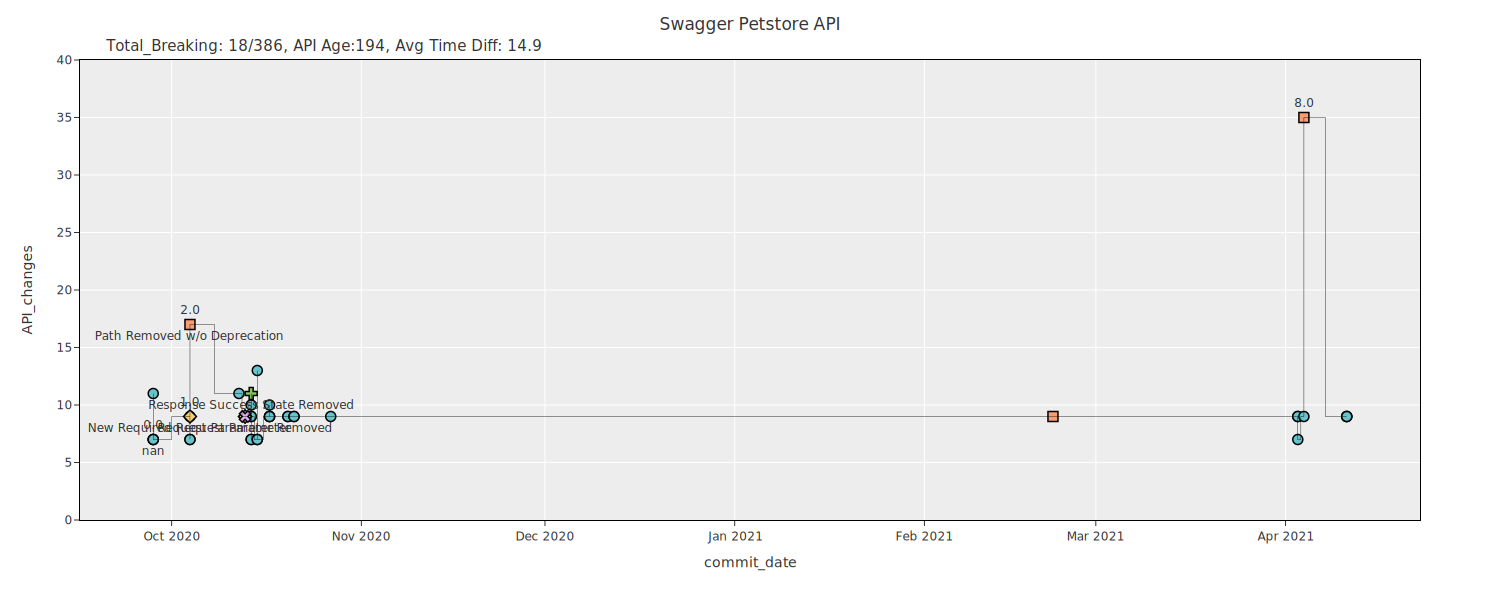

In [66]:
data= df.query("api_spec_id==115952").sort_values(by='commit_date',ascending=True)
data.fillna(0, inplace=True)
data['commit_date'] = pd.to_datetime(df['commit_date'])
data['dupe'] = data.content.where(~data.content.duplicated(), '')
data['dupe3']= data['count'].where(~data['count'].duplicated(), '')

import plotly.graph_objects as go
fig = go.Figure()

fig = px.scatter(data, x='commit_date', y='API_changes', color='content',symbol='content', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.add_trace(go.Scatter(mode='lines',
                         x=data["commit_date"],
                         y=data["API_changes"],
                         line_color='black',
                         line_width=0.4,
                         line_shape='hvh',
                         showlegend=False
                       )
             )

for _,row in data.iterrows():
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe'],
            showarrow=False,
            align='center',
            yanchor='bottom',
            yshift=-20,
            textangle=0)
       )
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe3'],
            showarrow=False,
            align='center',
            yanchor='top',
            yshift=25,
            textangle=0)
       )
fig.add_annotation(
    showarrow=False,
    text= f"Total_Breaking: {row['Total_Breaking_Changes']}/{row['Total_API_Changes']}, API Age:{row['Age']}, Avg Time Diff: {row['time_diff_y']}",
    xref='paper',
    font=dict(size=15),
    x=0.014,
    yref='paper',
    y=1.057
)
fig.update_layout(template='ggplot2', height=600,yaxis_range=[0, 40],width=1500,legend_title = 'Type of Breaking Change', title="Swagger Petstore API")
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_traces(marker_size=10, marker_line_width=1.5, marker_line_color='black', showlegend=False, textposition='bottom center')

fig.show("svg")


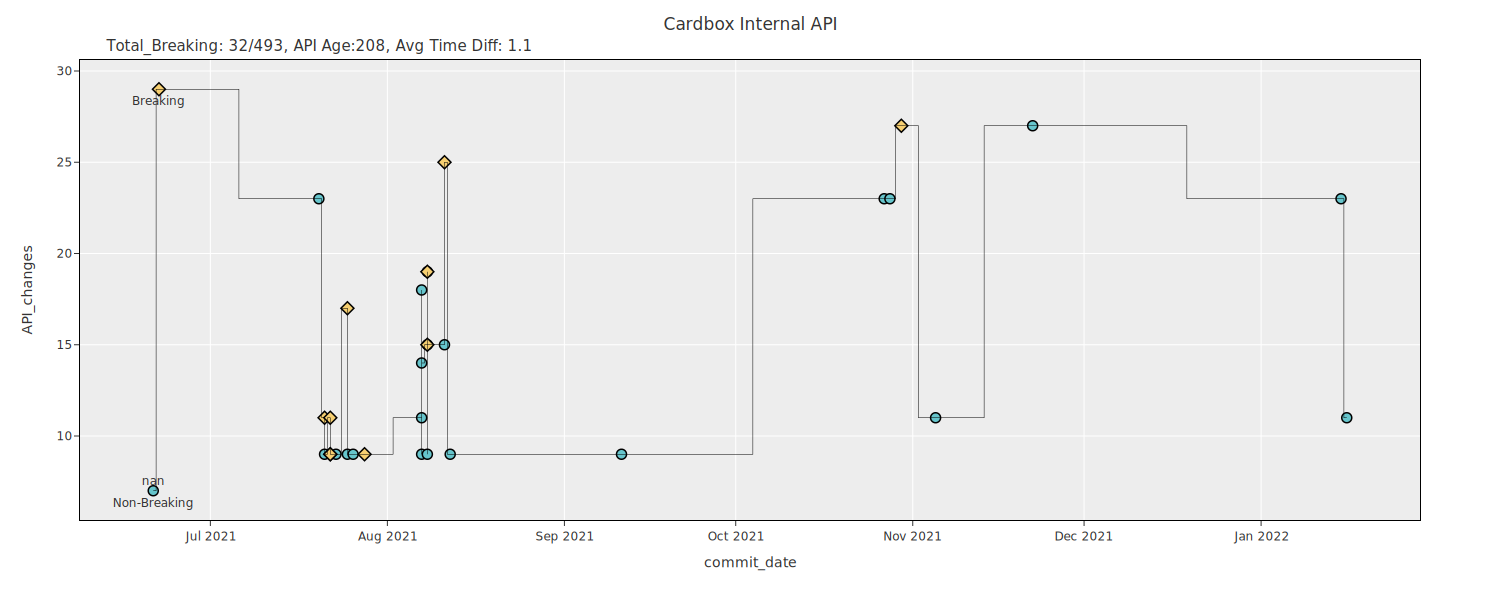

In [67]:
import plotly.graph_objects as go
dff = df.query("api_spec_id==152433").sort_values(by='commit_date',ascending=True)
dff['dupe'] = dff.label.where(~dff.label.duplicated(), '')
dff['dupe2'] = dff.type_of_change.where(~dff.type_of_change.duplicated(), '')

fig = go.Figure()
fig = px.scatter(dff, x='commit_date', y='API_changes', color='type_of_change',symbol='type_of_change', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.add_trace(go.Scatter(
    mode='lines',
    x=dff["commit_date"],
    y=dff["API_changes"],
    line_color='black',
    line_width=0.5,
    line_shape='hvh',
))

for _,row in dff.iterrows():
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe'],
            showarrow=False,
            align='center',
            yanchor='auto',
            yshift=10,
            textangle=-0)
       )
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe2'],
            showarrow=False,
            align='center',
            yanchor='bottom',
            yshift=-21,
            textangle=-0)
         )
fig.add_annotation(
    showarrow=False,
    text= f"Total_Breaking: {row['Total_Breaking_Changes']}/{row['Total_API_Changes']}, API Age:{row['Age']}, Avg Time Diff: {row['time_diff_y']}",
    xref='paper',
    font=dict(size=15),
    x=0.014,
    yref='paper',
    y=1.057
)


fig.update_layout(template='ggplot2',width=1500, height=600, title="Cardbox Internal API")
fig.update_traces(marker_size=10, marker_line_width=1.5, marker_line_color='black', showlegend=False, textposition='bottom center')
                              
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.show("svg")

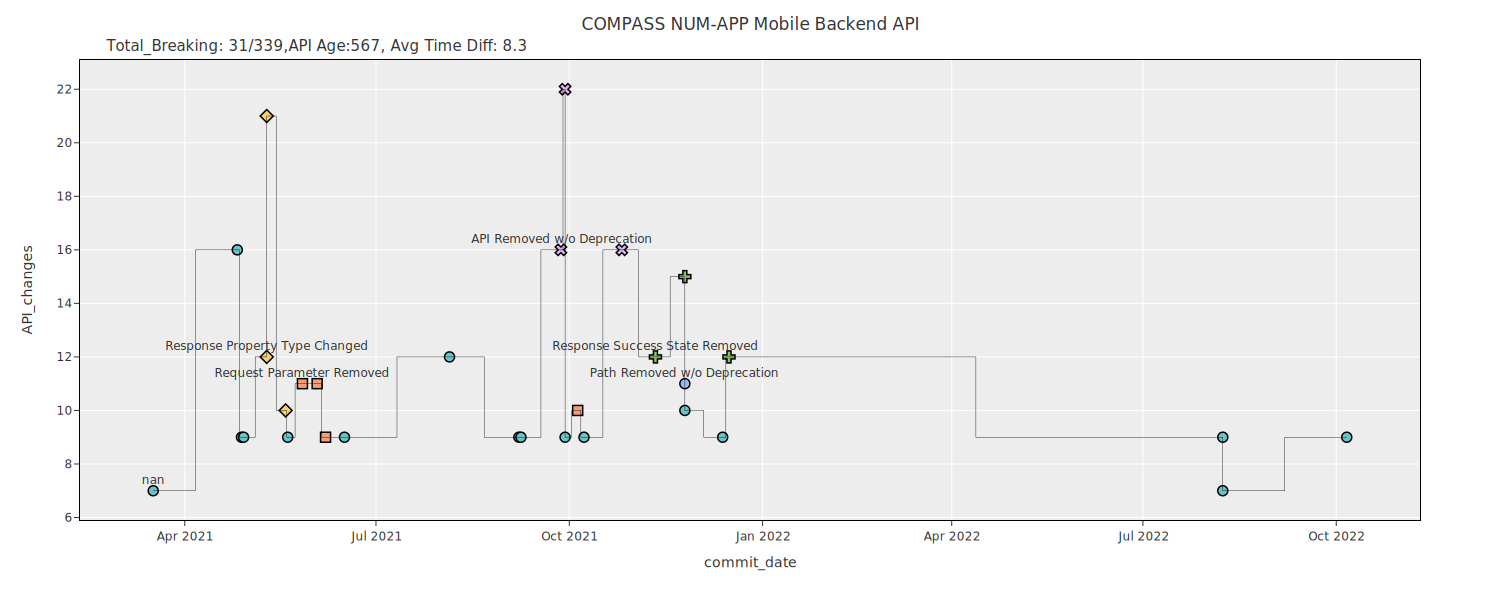

In [68]:
data= df.query("api_spec_id==225929").sort_values(by='commit_date',ascending=True)
data.fillna(0, inplace=True)
data['commit_date'] = pd.to_datetime(df['commit_date'])
data['dupe'] = data.content.where(~data.content.duplicated(), '')
data['dupe2']= data.label.where(~data.label.duplicated(), '')

import plotly.graph_objects as go
fig = go.Figure()

fig = px.scatter(data, x='commit_date', y='API_changes', color='content',symbol='content', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.add_trace(go.Scatter(mode='lines',
                         x=data["commit_date"],
                         y=data["API_changes"],
                         line_color='black',
                         line_width=0.4,
                         line_shape='hvh',
                         showlegend=False
                       )
             )

for _,row in data.iterrows():
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe'],
            showarrow=False,
            align='center',
            yanchor='top',
            yshift=21,
            textangle=0)
       )
fig.add_annotation(
    showarrow=False,
    text= f"Total_Breaking: {row['Total_Breaking_Changes']}/{row['Total_API_Changes']},API Age:{row['Age']}, Avg Time Diff: {row['time_diff_y']}",
    xref='paper',
    font=dict(size=15),
    x=0.014,
    yref='paper',
    y=1.057
)

fig.update_layout(template='ggplot2',legend_title = 'Type of Breaking Change', width=1500, height=600, title='COMPASS NUM-APP Mobile Backend API')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_traces(marker_size=10, marker_line_width=1.5, marker_line_color='black', showlegend=False, textposition='bottom center')

fig.show("svg")


## Age group 730-1460 (2-4)

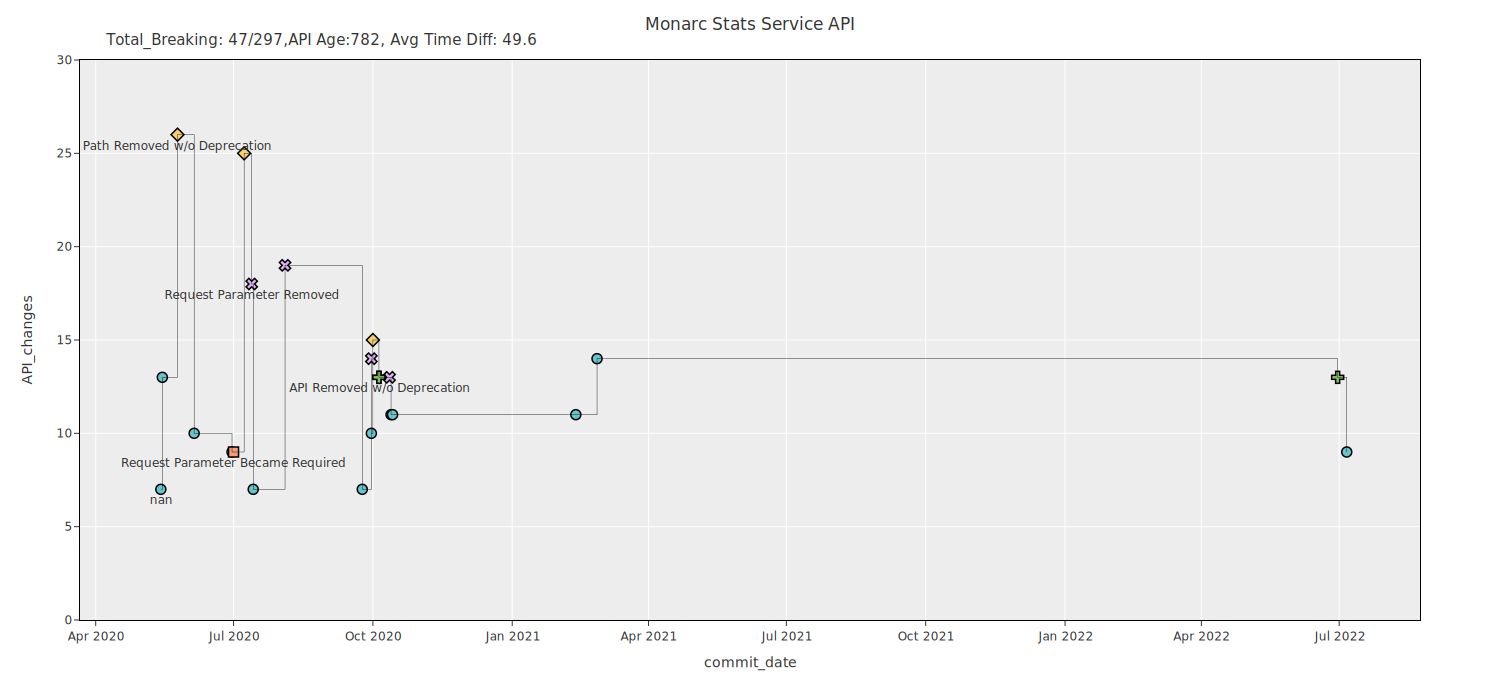

In [69]:
data= df.query("api_spec_id==209611").sort_values(by='commit_date',ascending=True)
data.fillna(0, inplace=True)
data['commit_date'] = pd.to_datetime(df['commit_date'])
data['dupe'] = data.content.where(~data.content.duplicated(), '')
data['dupe2']= data.label.where(~data.label.duplicated(), '')

import plotly.graph_objects as go
fig = go.Figure()

fig = px.scatter(data, x='commit_date', y='API_changes', color='content',symbol='content', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.add_trace(go.Scatter(mode='lines',
                         x=data["commit_date"],
                         y=data["API_changes"],
                         line_color='black',
                         line_width=0.4,
                         line_shape='hv',
                         showlegend=False
                       )
             )

for _,row in data.iterrows():
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe'],
            showarrow=False,
            align='center',
            yanchor='bottom',
            yshift=-20,
            textangle=0)
       )
fig.add_annotation(
    showarrow=False,
    text= f"Total_Breaking: {row['Total_Breaking_Changes']}/{row['Total_API_Changes']},API Age:{row['Age']}, Avg Time Diff: {row['time_diff_y']}",
    xref='paper',
    font=dict(size=15),
    x=0.014,
    yref='paper',
    y=1.057
)

fig.update_layout(template='ggplot2',legend_title = 'Type of Breaking Change', width=1500, height=700, yaxis_range = [0, 30], title='Monarc Stats Service API')

fig.update_traces(marker_size=10, marker_line_width=1.5, marker_line_color='black', showlegend=False, textposition='bottom center')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

fig.show("svg")


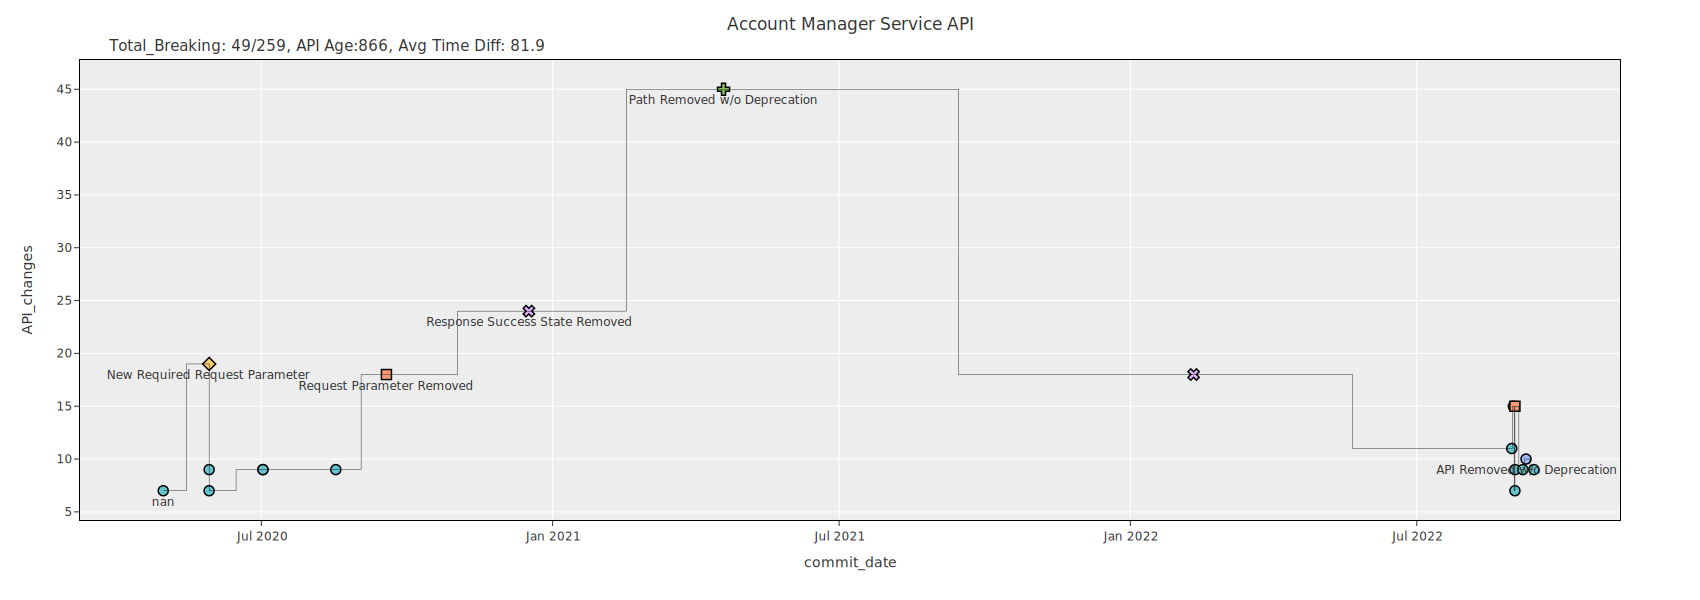

In [70]:
data= df.query("api_spec_id==237721").sort_values(by='commit_date',ascending=True)
data.fillna(0, inplace=True)
data['commit_date'] = pd.to_datetime(df['commit_date'])
data['dupe'] = data.content.where(~data.content.duplicated(), '')
data['dupe2']= data.label.where(~data.label.duplicated(), '')

import plotly.graph_objects as go
fig = go.Figure()

fig = px.scatter(data, x='commit_date', y='API_changes', color='content',symbol='content', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.add_trace(go.Scatter(mode='lines',
                         x=data["commit_date"],
                         y=data["API_changes"],
                         line_color='black',
                         line_width=0.4,
                         line_shape='hvh',
                         showlegend=False
                       )
             )

for _,row in data.iterrows():
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe'],
            showarrow=False,
            align='center',
            yanchor='bottom',
            yshift=-20,
            textangle=0)
       )

fig.add_annotation(
    showarrow=False,
    text= f"Total_Breaking: {row['Total_Breaking_Changes']}/{row['Total_API_Changes']}, API Age:{row['Age']}, Avg Time Diff: {row['time_diff_y']}",
    xref='paper',
    font=dict(size=15),
    x=0.014,
    yref='paper',
    y=1.057
)

fig.update_layout(template='ggplot2',legend_title = 'Type of Breaking Change', width=1700, height=600, title='Account Manager Service API') 
fig.update_traces(marker_size=10, marker_line_width=1.5, marker_line_color='black', showlegend=False, textposition='bottom center')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

fig.show("svg")


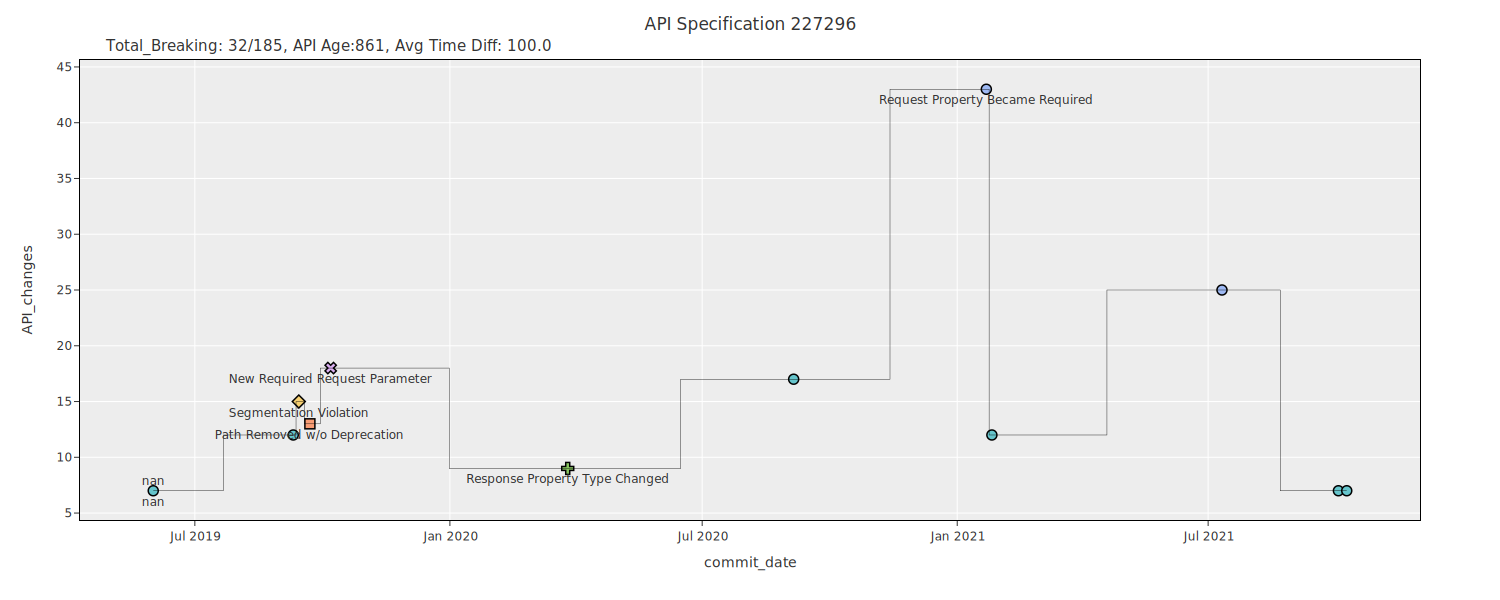

In [71]:
data= df.query("api_spec_id==227296").sort_values(by='commit_date',ascending=True)
data.fillna(0, inplace=True)
data['commit_date'] = pd.to_datetime(df['commit_date'])
data['dupe'] = data.content.where(~data.content.duplicated(), '')
data['dupe2']= data.label.where(~data.label.duplicated(), '')

import plotly.graph_objects as go
fig = go.Figure()

fig = px.scatter(data, x='commit_date', y='API_changes', color='content',symbol='content', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.add_trace(go.Scatter(mode='lines',
                         x=data["commit_date"],
                         y=data["API_changes"],
                         line_color='black',
                         line_width=0.4,
                         line_shape='hvh',
                         showlegend=False
                       )
             )

for _,row in data.iterrows():
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe'],
            showarrow=False,
            align='center',
            yanchor='bottom',
            yshift=-20,
            textangle=0)
       )
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe2'],
            showarrow=False,
            align='center',
            yanchor='top',
            yshift=20,
            textangle=-0)
         )
fig.add_annotation(
    showarrow=False,
    text= f"Total_Breaking: {row['Total_Breaking_Changes']}/{row['Total_API_Changes']}, API Age:{row['Age']}, Avg Time Diff: {row['time_diff_y']}",
    xref='paper',
    font=dict(size=15),
    x=0.014,
    yref='paper',
    y=1.057
)

fig.update_layout(template='ggplot2',legend_title = 'Type of Breaking Change', width=1500, height=600, title='API Specification 227296')
fig.update_traces(marker_size=10, marker_line_width=1.5, marker_line_color='black', showlegend=False, textposition='bottom center')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.show("svg")


## Age 1460-2190 (4-6)

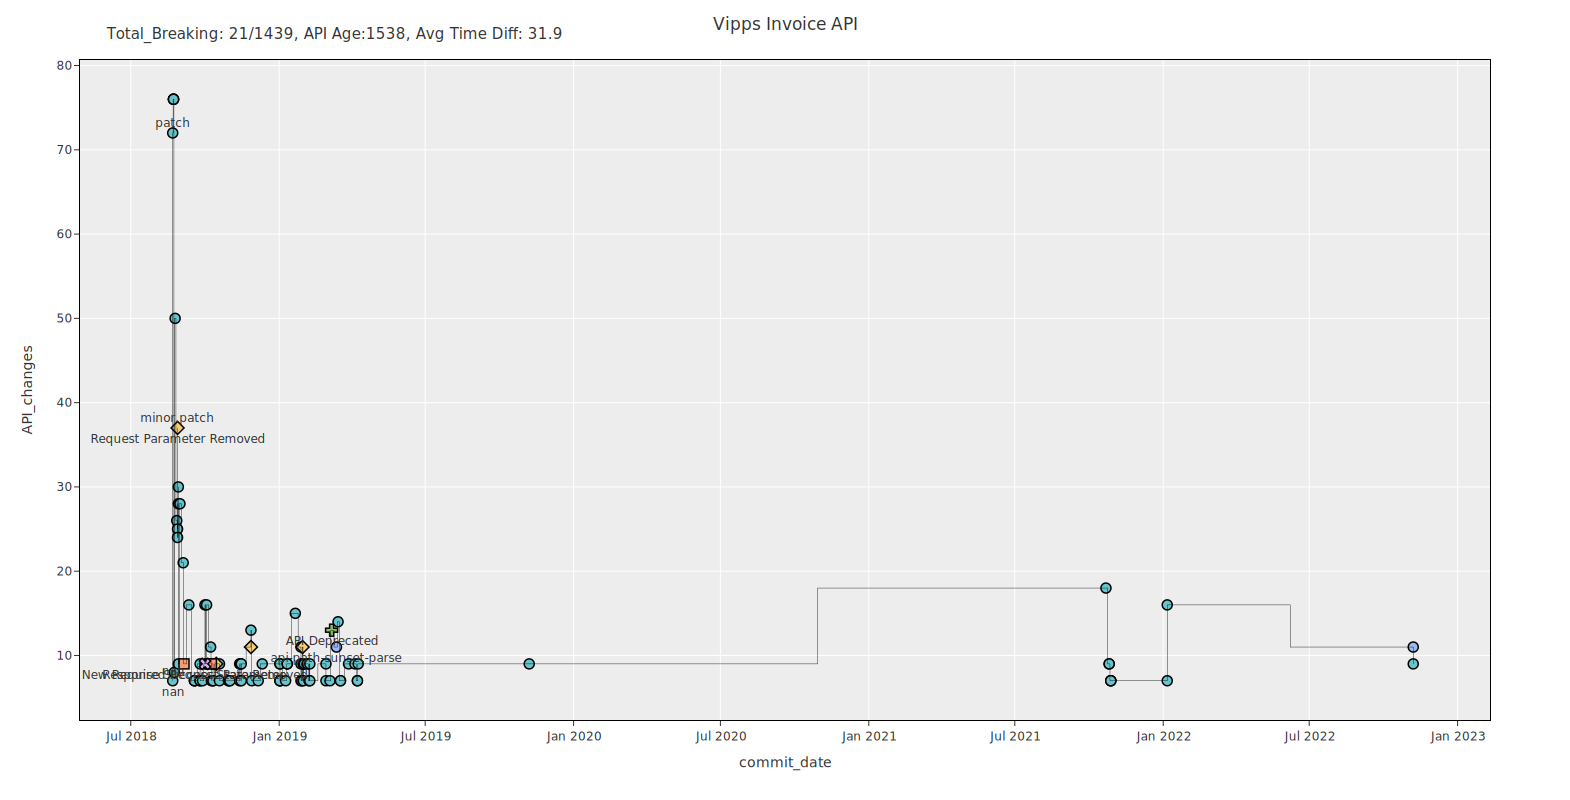

In [72]:
data= df.query("api_spec_id==121061").sort_values(by='commit_date',ascending=True)
data.fillna(0, inplace=True)
data['commit_date'] = pd.to_datetime(df['commit_date'])
data['dupe'] = data.content.where(~data.content.duplicated(), '')
data['dupe2']= data.label.where(~data.label.duplicated(), '')

import plotly.graph_objects as go
fig = go.Figure()

fig = px.scatter(data, x='commit_date', y='API_changes', color='content',symbol='content', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.add_trace(go.Scatter(mode='lines',
                         x=data["commit_date"],
                         y=data["API_changes"],
                         line_color='black',
                         line_width=0.4,
                         line_shape='hvh',
                         showlegend=False
                       )
             )

for _,row in data.iterrows():
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe'],
            showarrow=False,
            align='center',
            yanchor='bottom',
            yshift=-20,
            textangle=0)
       )
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe2'],
            showarrow=False,
            align='center',
            yanchor='top',
            yshift=20,
            textangle=-0)
         )
fig.add_annotation(
    showarrow=False,
    text= f"Total_Breaking: {row['Total_Breaking_Changes']}/{row['Total_API_Changes']}, API Age:{row['Age']}, Avg Time Diff: {row['time_diff_y']}",
    xref='paper',
    font=dict(size=15),
    x=0.014,
    yref='paper',
    y=1.057
)

fig.update_layout(template='ggplot2',legend_title = 'Type of Breaking Change', width=1570, height=800, title='Vipps Invoice API')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_traces(marker_size=10,marker_line_width=1.5, marker_line_color='black', showlegend=False, textposition='bottom center')

fig.show("svg")


## Age 365-700 , patch

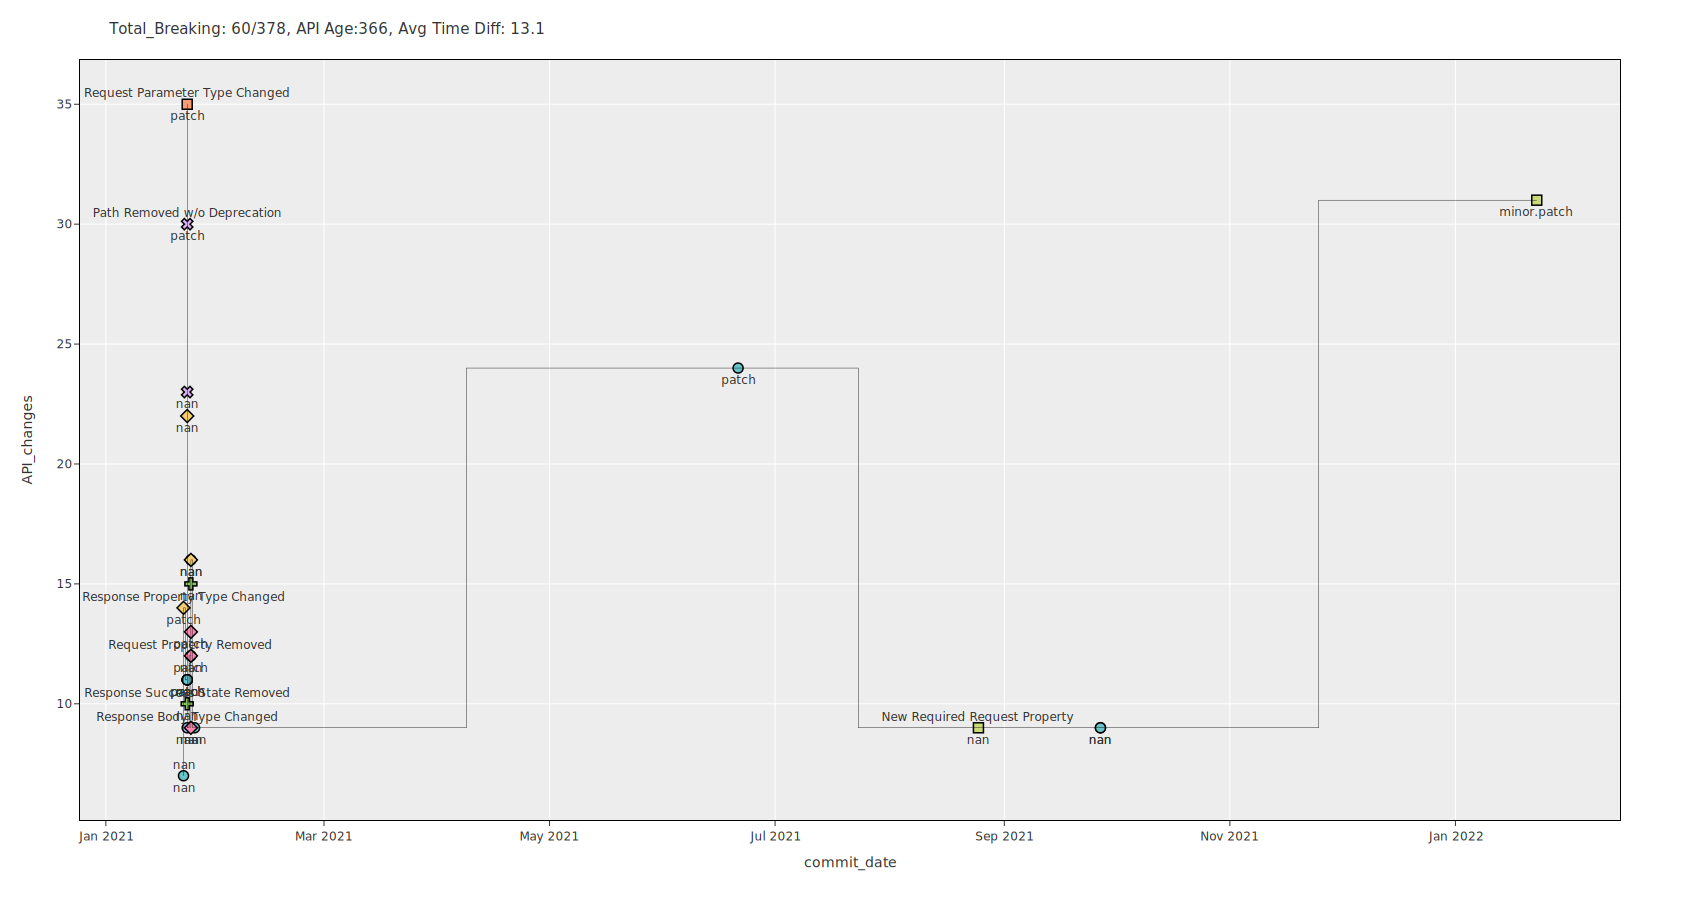

In [73]:
data= df.query("api_spec_id==151200").sort_values(by='commit_date',ascending=True)
data.fillna(0, inplace=True)
data['commit_date'] = pd.to_datetime(df['commit_date'])
data['dupe'] = data.content.where(~data.content.duplicated(), '')
data['dupe2']= data.label.where(~data.label.duplicated(), '')

import plotly.graph_objects as go
fig = go.Figure()

fig = px.scatter(data, x='commit_date', y='API_changes', color='content',symbol='content', color_discrete_sequence=px.colors.qualitative.Pastel)
fig.add_trace(go.Scatter(mode='lines',
                         x=data["commit_date"],
                         y=data["API_changes"],
                         line_color='black',
                         line_width=0.4,
                         line_shape='hvh',
                         showlegend=False
                       )
             )

for _,row in data.iterrows():
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['dupe'],
            showarrow=False,
            align='center',
            yanchor='top',
            yshift=21,
            textangle=0)
       )
    fig.add_annotation(
        go.layout.Annotation(
            x=row["commit_date"],
            y=row["API_changes"],
            text=row['label'],
            showarrow=False,
            align='center',
            yanchor='bottom',
            yshift=-21,
            textangle=-0)
            )
fig.add_annotation(
    showarrow=False,
    text= f"Total_Breaking: {row['Total_Breaking_Changes']}/{row['Total_API_Changes']}, API Age:{row['Age']}, Avg Time Diff: {row['time_diff_y']}",
    xref='paper',
    font=dict(size=15),
    x=0.014,
    yref='paper',
    y=1.057
)
fig.update_layout(template='ggplot2',legend_title = 'Type of Breaking Change', width=1700, height=900)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_traces(marker_size=10, marker_line_width=1.5, marker_line_color='black', showlegend=False, textposition='bottom center')

fig.show("svg")


/var/folders/27/mp6sy3_d6_lgz19hyp_8n8z40000gn/T/ipykernel_6790/2132756917.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



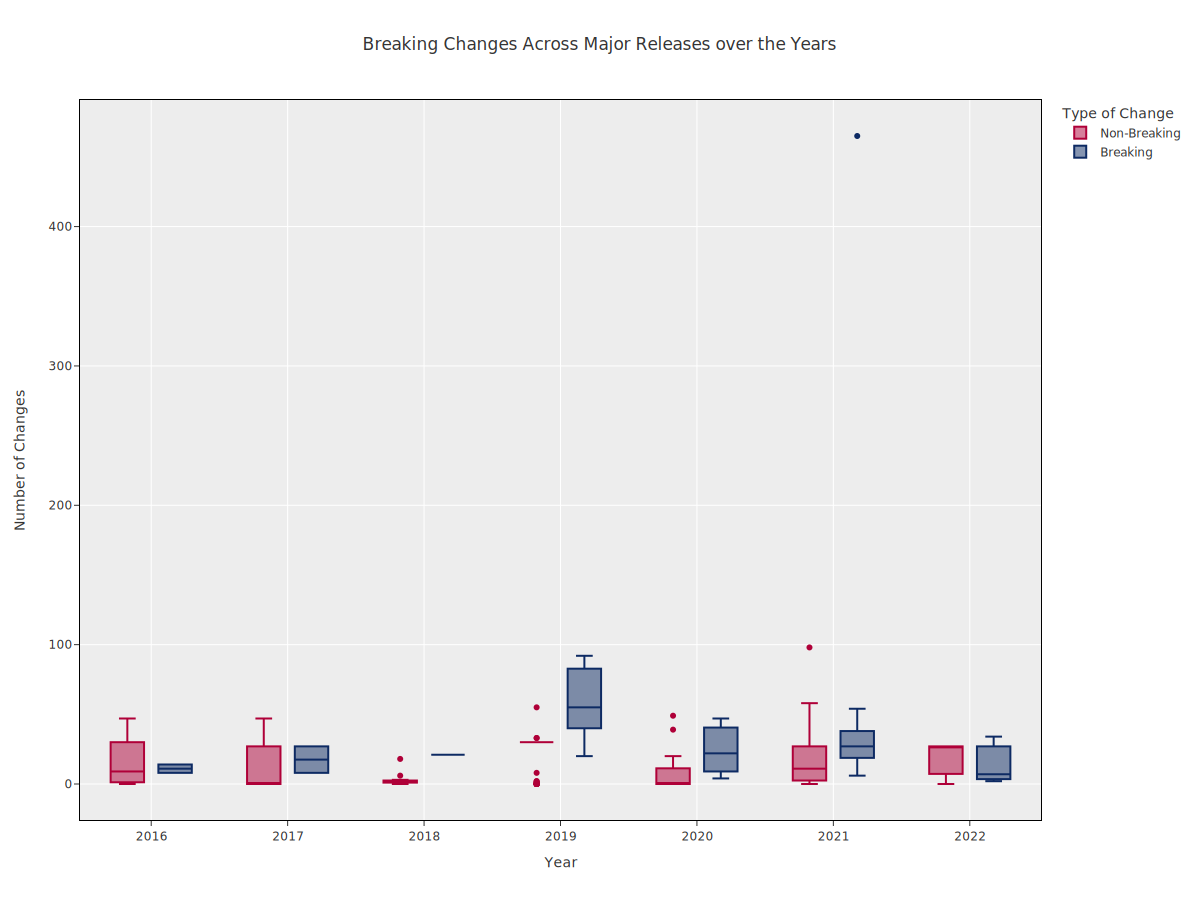

In [74]:
import plotly.graph_objs as go
import plotly.express as px


# Filter the DataFrame to include only 'major', 'minor', and 'patch' labels
df_filtered = df[df['label'].isin(['major'])]

# Extract the year from the 'date' column
df_filtered['Year'] = df_filtered['commit_date'].dt.year
df_filtered = df_filtered[(df_filtered['Year'] != 2015) & (df_filtered['Year'] != 2023)]

# Create the plot
fig = px.box(df_filtered, x="Year", y="Total_Breaking_Changes", color="type_of_change", color_discrete_sequence=px.colors.qualitative.Dark24_r, title='Breaking Changes Across Major Releases over the Years')
fig.update_layout(template='ggplot2', legend_title = 'Type of Change', width=1200, height=900)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, title='Year')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, title='Number of Changes')
fig.show("svg")

/var/folders/27/mp6sy3_d6_lgz19hyp_8n8z40000gn/T/ipykernel_6790/2271992357.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



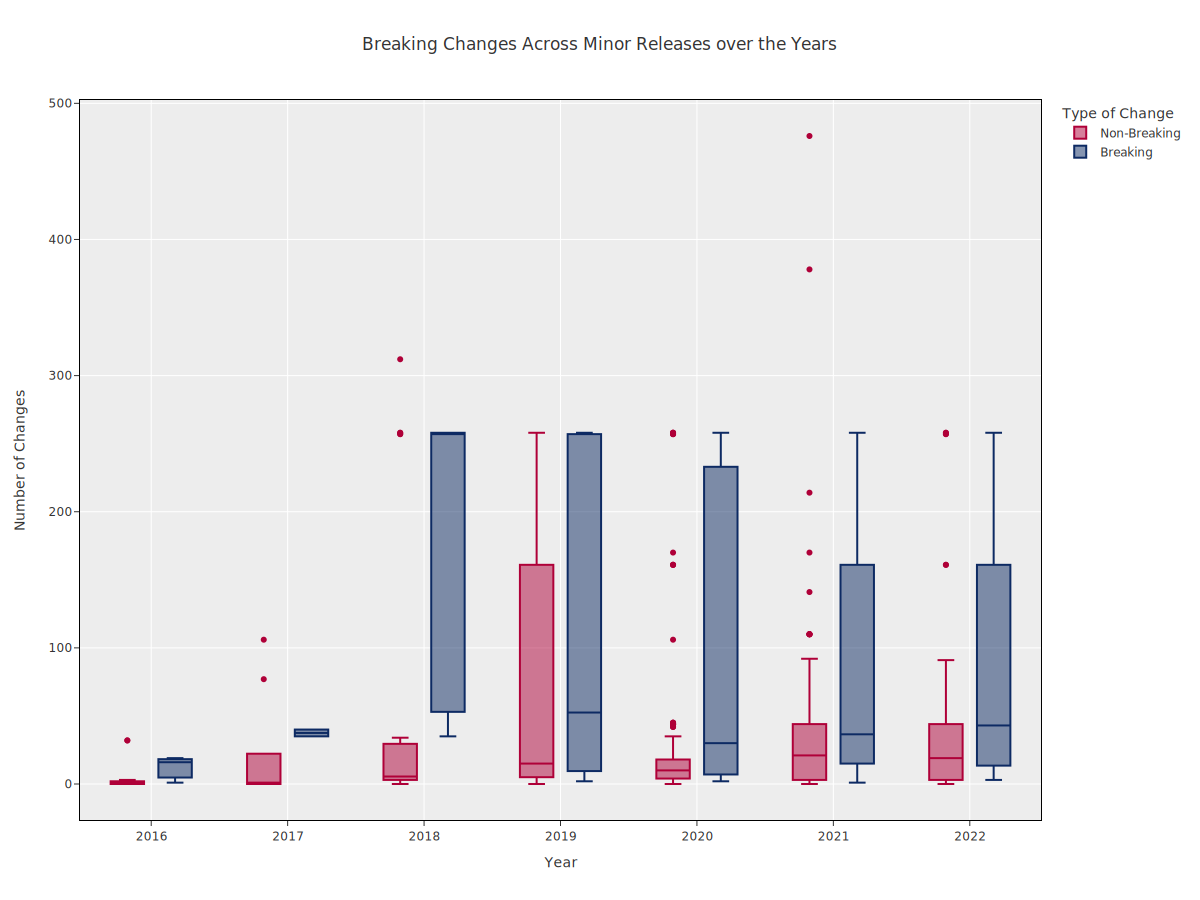

In [75]:
import plotly.graph_objs as go
import plotly.express as px


# Filter the DataFrame to include only 'major', 'minor', and 'patch' labels
df_filtered = df[df['label'].isin(['minor'])]

# Extract the year from the 'date' column
df_filtered['Year'] = df_filtered['commit_date'].dt.year
df_filtered = df_filtered[(df_filtered['Year'] != 2015) & (df_filtered['Year'] != 2023)]

# Create the plot
fig = px.box(df_filtered, x="Year", y="Total_Breaking_Changes", color="type_of_change", color_discrete_sequence=px.colors.qualitative.Dark24_r, title='Breaking Changes Across Minor Releases over the Years')
fig.update_layout(template='ggplot2', legend_title = 'Type of Change', width=1200, height=900)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, title='Year')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, title='Number of Changes')
fig.show("svg")

/var/folders/27/mp6sy3_d6_lgz19hyp_8n8z40000gn/T/ipykernel_6790/769216345.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



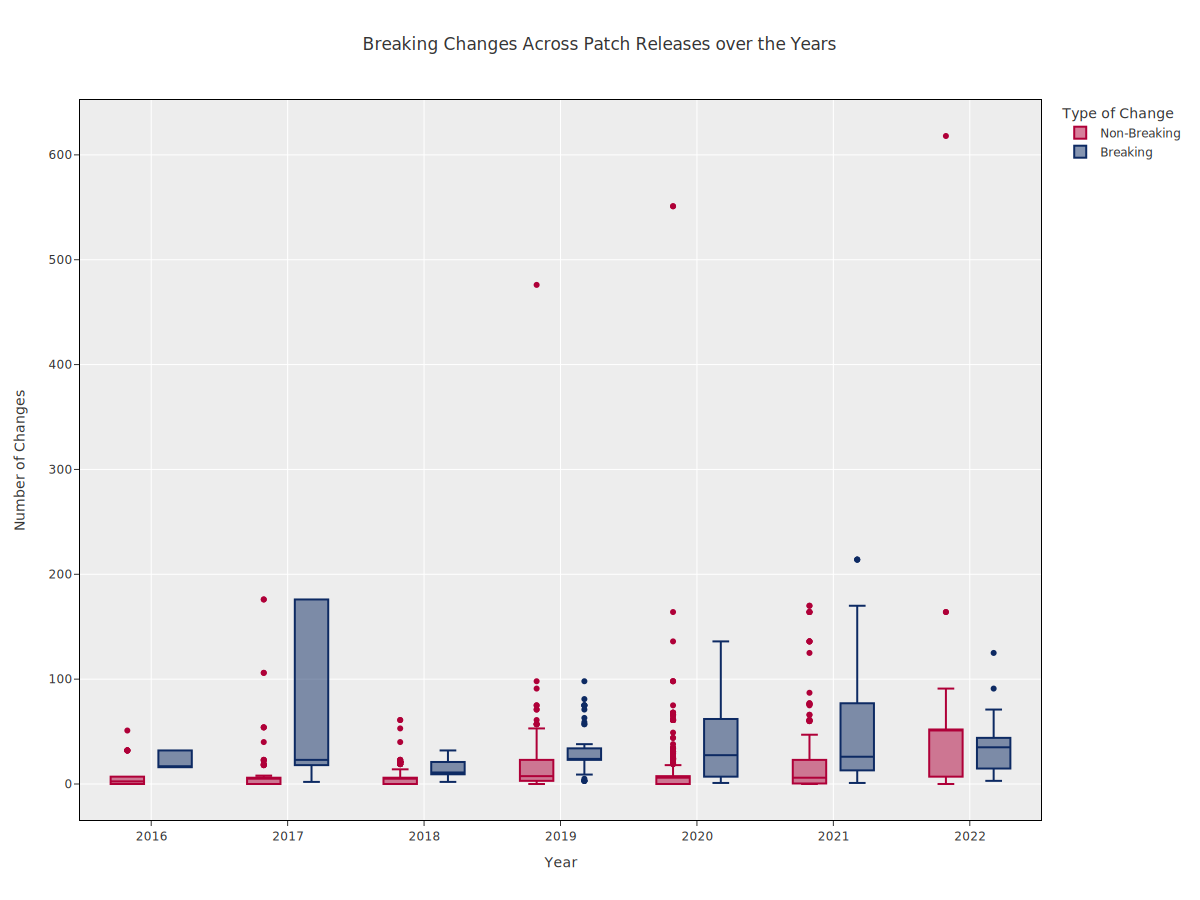

In [76]:
import plotly.graph_objs as go
import plotly.express as px


# Filter the DataFrame to include only 'major', 'minor', and 'patch' labels
df_filtered = df[df['label'].isin(['patch'])]

# Extract the year from the 'date' column
df_filtered['Year'] = df_filtered['commit_date'].dt.year
df_filtered = df_filtered[(df_filtered['Year'] != 2015) & (df_filtered['Year'] != 2023)]

# Create the plot
fig = px.box(df_filtered, x="Year", y="Total_Breaking_Changes", color="type_of_change", color_discrete_sequence=px.colors.qualitative.Dark24_r, title='Breaking Changes Across Patch Releases over the Years')
fig.update_layout(template='ggplot2', legend_title = 'Type of Change', width=1200, height=900)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, title='Year')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, title='Number of Changes')
fig.show("svg")

/var/folders/27/mp6sy3_d6_lgz19hyp_8n8z40000gn/T/ipykernel_6790/2137042912.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



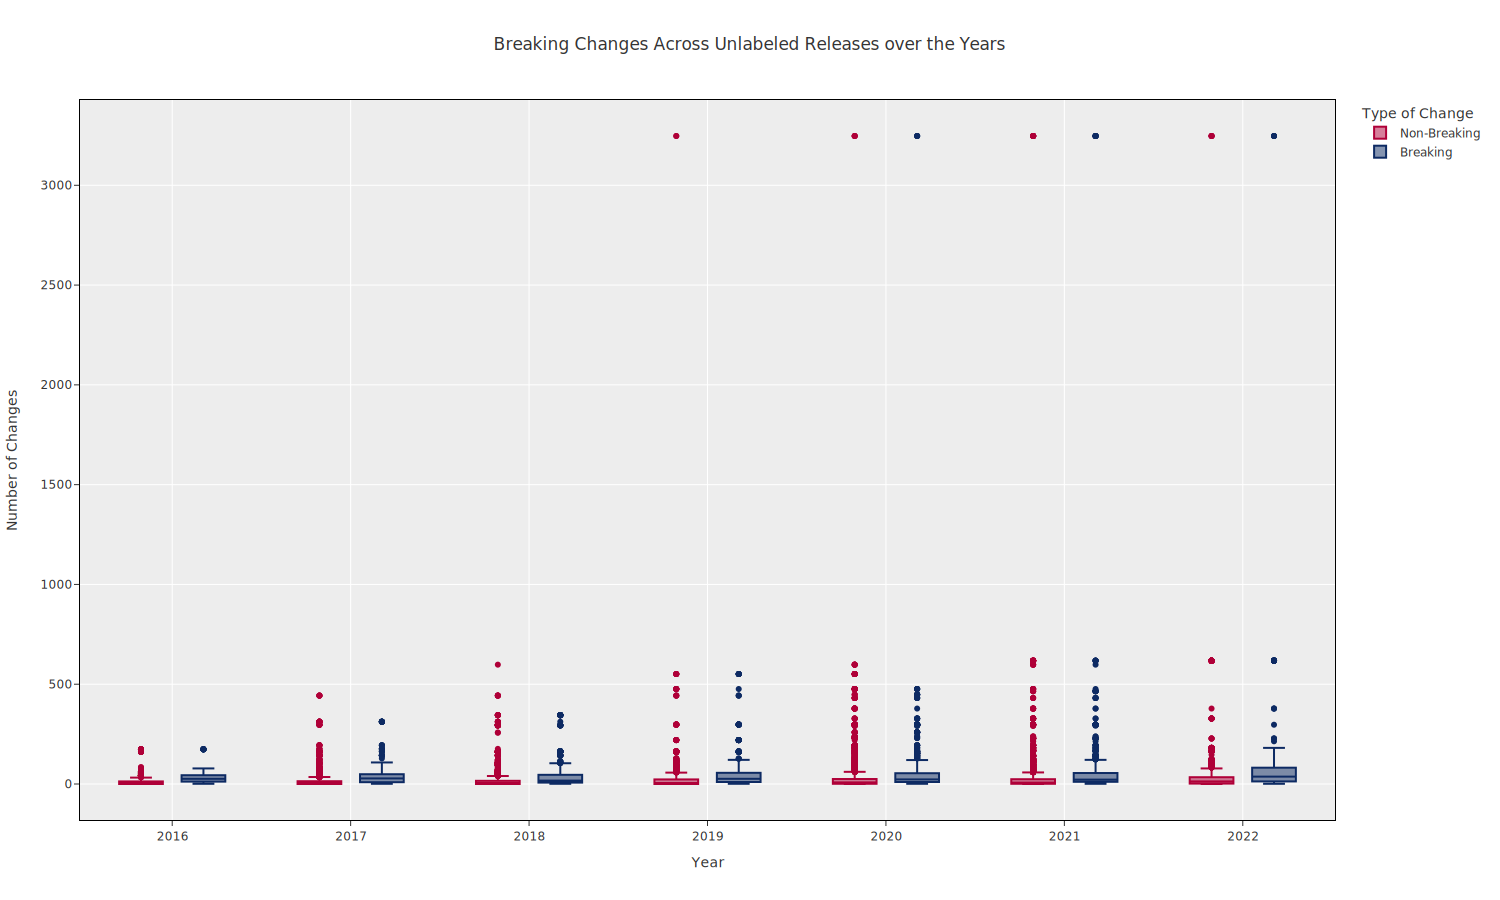

In [77]:
import plotly.graph_objs as go
import plotly.express as px


# Filter the DataFrame to include only nan labels
df_filtered = df[df['label'].isin(['nan'])]

# Extract the year from the 'date' column
df_filtered['Year'] = df_filtered['commit_date'].dt.year
df_filtered = df_filtered[(df_filtered['Year'] != 2014) & (df_filtered['Year'] != 2015 ) & (df_filtered['Year'] != 2023)]

# Create the plot
fig = px.box(df_filtered, x="Year", y="Total_Breaking_Changes", color="type_of_change", color_discrete_sequence=px.colors.qualitative.Dark24_r, title='Breaking Changes Across Unlabeled Releases over the Years')
fig.update_layout(template='ggplot2', legend_title = 'Type of Change', width=1500, height=900)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, title='Year')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, title='Number of Changes')
fig.show("svg")

In [78]:
df['Year'] = pd.to_datetime(df['commit_date']).dt.year

In [79]:
df['Year'].value_counts()

Year
2020    19240
2021    15802
2019    12128
2017     8589
2018     7534
2022     6301
2016     4756
2015     1610
2014        5
2023        4
Name: count, dtype: int64

In [80]:
df['total_api_changes_year'] = df.groupby('Year').Total_API_Changes.transform('count')

In [81]:
df.to_csv('data.csv', index=False)